In [1]:
import os
import pandas as pd
import numpy as np
from ultralytics import YOLO
from PIL import Image
from IPython.display import display
from sahi.utils.yolov8 import (
    download_yolov8s_model, download_yolov8s_seg_model
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image as IPImage
from scipy.ndimage import maximum_filter

In [2]:
test = "./test_images"

In [3]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path="./runs/segment/train36/weights/best.pt",
    confidence_threshold=0.8,
    device="cuda:0",
)

/home/p.kuznetsov/runaway/venv/lib/python3.9/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='c

In [4]:
images = []
for subdirectory in os.listdir(test):
    sub_path = os.path.join(test, subdirectory)
    for date in os.listdir(sub_path):
        date_path = os.path.join(sub_path, date)
        for file in os.listdir(date_path):
            if file.endswith(".png"):
                file_path = os.path.join(date_path, file)
                images.append((file_path, subdirectory))

In [5]:
predictions = []
buffer_size = 20
filter_size = 2 * buffer_size + 1
for i in range(0, len(images), 15):
    batch = images[i:i+15]
    buffered_results = []
    for path, _ in batch:
        result = get_sliced_prediction(
            path,
            detection_model,
            slice_height = 200,
            slice_width = 200,
            overlap_height_ratio = 0.2,
            overlap_width_ratio = 0.2
        )
        if len(result.object_prediction_list) == 0:
            continue
        mask = result.object_prediction_list[0].mask.bool_mask
        buffered_result = maximum_filter(mask, size=filter_size)
        for i in range(1, len(result.object_prediction_list)):
            mask = result.object_prediction_list[i].mask.bool_mask
            buffered_mask = maximum_filter(mask, size=filter_size)
            buffered_result = np.logical_or(buffered_result, buffered_mask)
        buffered_results.append(buffered_result)
    stacked_results = np.stack(buffered_results)
    final_result = np.any(stacked_results, axis=0)
    predictions.append((final_result, batch[0][1]))

Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
Performing prediction on 100 slices.
P

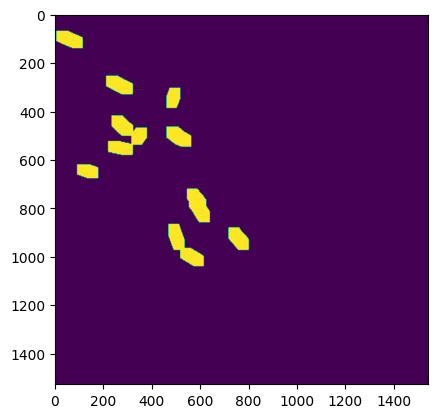

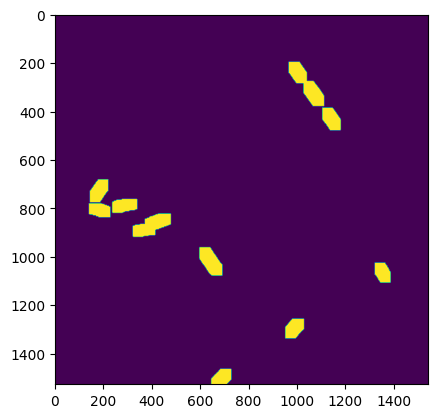

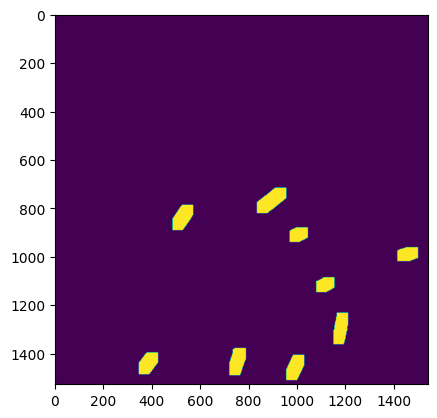

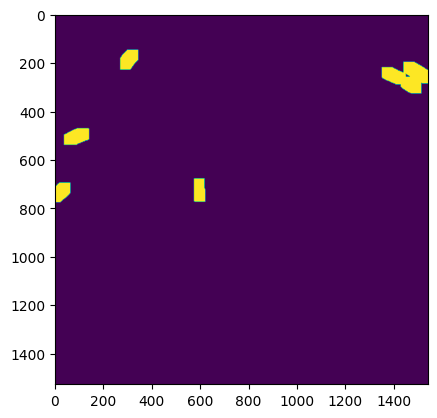

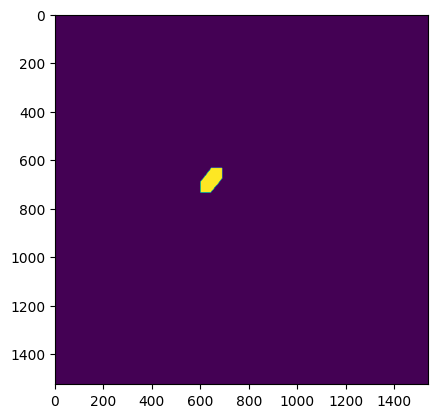

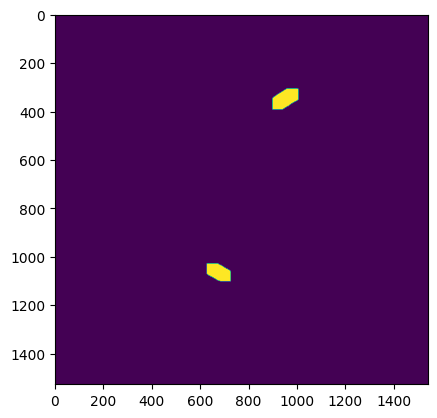

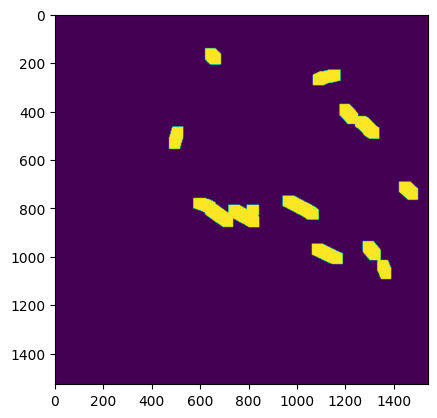

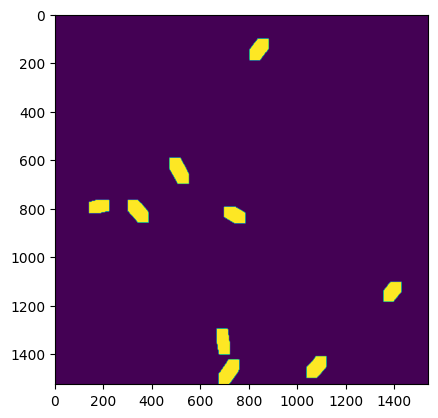

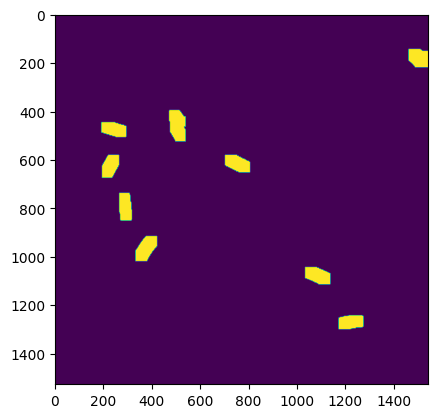

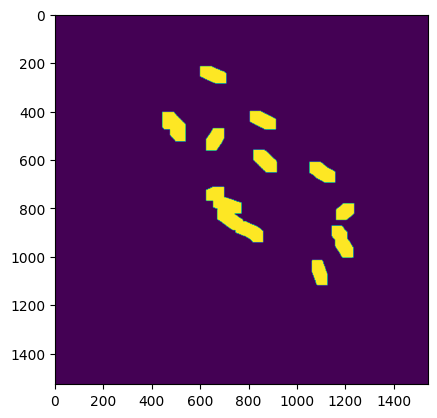

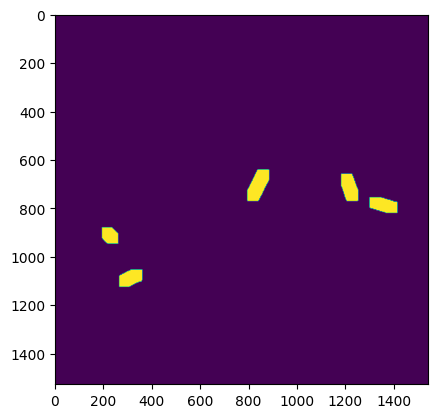

In [6]:
import matplotlib.pyplot as plt

for prediction, _ in predictions:
    plt.imshow(prediction)
    plt.show()

In [22]:
sample = pd.read_csv("./SampleSubmission.csv")

In [23]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968502 entries, 0 to 3968501
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tile_row_column  object 
 1   label            float64
dtypes: float64(1), object(1)
memory usage: 60.6+ MB


In [9]:
for i in range(len(predictions)):
    prediction, id = predictions[i]
    cleaned_id = "Tileaoi_" + id[2:].replace(".shp", "")
    predictions[i] = (prediction, cleaned_id)

In [24]:
pred_map = {key: value for value, key in predictions}

In [25]:
sample["prefix"] = sample["tile_row_column"].str[:13]

In [26]:
sample["label"] = sample["prefix"].map(pred_map)

In [27]:
sample["x"] = sample["tile_row_column"].str[14:].str.split("_").str[0].astype(int)
sample["y"] = sample["tile_row_column"].str[14:].str.split("_").str[1].astype(int)

In [28]:
sample['label'] = sample.apply(lambda row: row['label'][row['y'], row['x']], axis=1)

In [29]:
sample = sample.drop(columns=["prefix", "x", "y"])

In [30]:
sample["label"] = sample["label"].astype(int)

In [31]:
sample = sample.sort_values(by="label", ascending=False)

In [32]:
sample = sample.head(200000)

In [33]:
count_of_ones = (sample['label'] == 1).sum()
print(f"Count of ones: {count_of_ones}")

Count of ones: 80770


In [34]:
sample = sample[sample['label'] != 0]

In [35]:
sample.to_csv("submission.csv", index=False)